In [8]:
### Description:
# In these cells, we constructed the wavelet line approach for the 2D case
# We found that our previous approach was inefficient. By calculating the 
# argument of the wavelet and applying the grid on the output, the program
# was really calculating the wavelet coefficient over all data points and then
# stored only the values that were in the grid. 

# What we did not is just define the truncated mesh grid and calculated the 
# wavelet coefficient with the truncated grid.

### Further Considerations:
# HOWEVER, though it is more efficient, once we deal with bins containing 100x
# more datapoints, we will run into the same memory problem with the nodes.

# At that point, we would need to calculate the wavelet coefficients using
# a nested for loop where all the values are calculated at once. But,
# as the time will increase by about a factor of 10, we again return to 
# applying this "_line" approach for each node, where each calculation would 
# take a 1-15 minutes.

In [9]:
import os
os.chdir('/het/p4/ramirez/gcewavelets/skysearch/code/')

import numpy as np
import sys, os
import _maps as maps

import healpy as hp
import astropy_healpix

import matplotlib.pyplot as plt
import matplotlib as mpl


from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage import data, img_as_float

from tqdm import tqdm

In [10]:
# load local directory
username="ramirez"
local_dir = "/het/p4/"+username+"/gcewavelets/skysearch/"
maps_dir = "/het/p4/"+username+"/gcewavelets/skysearch/data/maps/"

# ---
 # Block: Specify map ids
model = 'ilias_60x60' # only available option: SA0
trial_id = str(0)
model_dir = maps_dir + (model + '_' + trial_id + '/')
energy_bin = '16'
map_type = 'all'

# inj_ids
inj_id_list = [1008,1009,1010,1015,1020,1025,1030,1035]
N_counts_list = [8,9,10,15,20,25,30,35]

n_inj = 6
inj_id = str(inj_id_list[n_inj])
N_counts = N_counts_list[n_inj]

# load events from map 
if energy_bin == 'all' or energy_bin == str(-1):
    if map_type == 'bkgd':
        map_dir = model_dir + 'bkgd/'
    elif map_type == 'all':
        map_dir = model_dir + ('bkgd_wps_' + inj_id + '/') 
else:
    ie = int(float(energy_bin))
    if map_type == 'bkgd':
        bkgd_dir = model_dir + 'bkgd/'
        map_dir = bkgd_dir + 'energy_bin_' + str(ie) + '/'
    elif map_type == 'all':
        bkgd_wps_dir = model_dir + ('bkgd_wps_' + inj_id + '/')
        map_dir = bkgd_wps_dir + 'energy_bin_' + str(ie) + '/'  

data_dir = map_dir + 'projected_maps/'
# ---

# load father pixel and data
npix = 112
patch_dir = data_dir + 'map_' + str(npix) + '/'

In [4]:
a_deg = 0.1
str_a_deg = str.format('{0:.5f}',a_deg)

wavelet_name = 'mexh'
grid_scale_deg = 0.1
str_grid_scale_deg = str.format('{0:.4f}',grid_scale_deg)
file_name = wavelet_name + '_' + 'coefficient_map' + '_' + str_a_deg + '_' + str_grid_scale_deg + '.npy'
cwt_map_og = np.load(patch_dir + file_name, allow_pickle = True)
projected_map = dict(np.load(patch_dir + 'projected_map_dict.npz'))

# decided to separate grid and projected maps into two different dictionaries
# grid is defined using the total background map for all energies
bkgd_patch_dir_all_energies = model_dir + 'bkgd/' + 'energy_bin_' + str(ie) + '/' + 'projected_maps/' + 'map_' + str(npix) + '/'
grid_dict = dict(np.load(bkgd_patch_dir_all_energies + 'grid_dict_' + str_grid_scale_deg + '_' + '.npz'))
mesh_bxby = grid_dict['rectangular_grid']
grid = grid_dict['grid']

In [7]:
grid_dict.keys()

dict_keys(['grid', 'rectangular_grid', 'rectangular_grid_points', 'grid_flat', 'arr_bx_plot', 'arr_by_plot'])

In [25]:
r_out_edge = projected_map['outer_region_edge']
x_out_edge = r_out_edge[:,0] ; y_out_edge = r_out_edge[:,1]
bx_min, bx_max, by_min, by_max = [np.min(x_out_edge), np.max(x_out_edge),
                                  np.min(y_out_edge), np.max(y_out_edge)]

In [26]:
scale = 0.1 * np.pi / 180
step_size = scale 
mesh_bxby, arr_b, arr_bx_plot, arr_by_plot = maps.build_mesh_(bx_min, bx_max, by_min, by_max, step_size, step_size, return_arrays_for_plotting=True)
arr_bx = 0.5 * (arr_bx_plot[:-1] + arr_bx_plot[1:])
arr_by = 0.5 * (arr_by_plot[:-1] + arr_by_plot[1:])

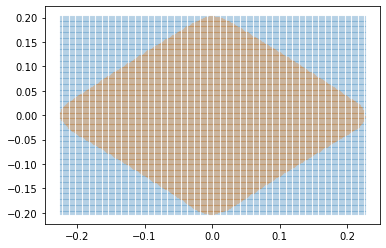

In [27]:
plt.scatter(mesh_bxby[:,:,0], mesh_bxby[:,:,1], s = 0.01)
plt.scatter(mesh_bxby[grid][:,0], mesh_bxby[grid][:,1], s = 0.01)

In [28]:
print(mesh_bxby[grid])

[[-0.00496625 -0.20229968]
 [-0.00322092 -0.20229968]
 [-0.00147559 -0.20229968]
 ...
 [-0.00147559  0.20261671]
 [ 0.00026974  0.20261671]
 [ 0.00201507  0.20261671]]


[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[[-0.00496625 -0.20229968]]


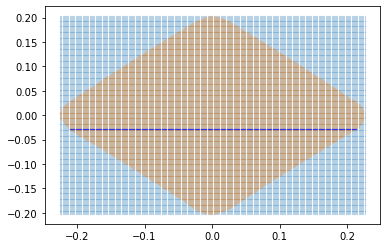

In [29]:
by = arr_by[100]

ny = np.where(mesh_bxby[grid][:,1] == by)
print(grid)
arr_bx_line = mesh_bxby[grid][ny]

arr_bx_line = mesh_bxby[grid][ny]
grid_bx = ( mesh_bxby == mesh_bxby[grid][0,:] ).all(axis = 2)
print(mesh_bxby[grid_bx])

grid_bx = ( mesh_bxby[:,:,1] == by ) & (grid)

plt.scatter(mesh_bxby[:,:,0], mesh_bxby[:,:,1], s = 0.01)
plt.scatter(mesh_bxby[grid][:,0], mesh_bxby[grid][:,1], s = 0.01)
# plt.scatter(arr_bx_line[:,0], arr_bx_line[:,1], s = 0.1, c = 'g')
plt.scatter(mesh_bxby[grid_bx][:,0], mesh_bxby[grid_bx][:,1], s = 0.1, c = 'b')

In [30]:
print(arr_bx.shape)

(259,)


In [ ]:
import _wavelets as wt

data = projected_map['all_points']
a = a_deg * np.pi / 180
arr_a = np.array([a])
Na = len(arr_a)

# define 2d wavelet
mexh = wt._2d_wavelet(wavelet_name)

# pre-allocate wavelet coefficient map 
N_data, N_dim = data.shape
Ny, Nx = mesh_bxby.shape[:-1]
coefficient_map = np.zeros((Ny, Nx, 1))

for ny in tqdm(range(Ny)):
    by = arr_by[ny]
    ny = np.where(mesh_bxby[grid][:,1] == by)

    grid_bx = ( mesh_bxby[:,:,1] == by ) & (grid)

    mesh_bxby_grid_bx = mesh_bxby[grid_bx]
    
    # broadcast arrays in wavelet calculation
    buf_data = data[np.newaxis,np.newaxis,np.newaxis]
    buf_mesh_bxby = mesh_bxby_grid_bx[:,np.newaxis,np.newaxis,np.newaxis]
    buf_arr_a = arr_a[np.newaxis, np.newaxis, :, np.newaxis, np.newaxis]

    # calculate arguments of wavelet coefficients
    # buf_grid = grid[:,:,np.newaxis,np.newaxis,np.newaxis]
    buf_arr_arg_grid =  ( (buf_data - buf_mesh_bxby ) / buf_arr_a )

    # calculate wavelet coefficients
    buf_mexh_output_grid = mexh.base_fct(buf_arr_arg_grid)

    # remove two dimensions of a-array to divide mexh
    buf_arr_a_sq = np.squeeze(buf_arr_a, axis = -1)
    buf_arr_a_sq = np.squeeze(buf_arr_a_sq, axis = -1)

    # estimate wavelet coefficient by summing over datapoints
    coefficient_map_flat = np.sum(buf_mexh_output_grid, axis = -1) / buf_arr_a_sq / N_data
    coefficient_map_flat_sq = np.squeeze(coefficient_map_flat, axis = -1)

    # note that buf_arr_arg_grid is flattened relative to the shape of mesh_bxby
    # applying grid to coefficient_map automatically flattens coefficient_map to match to coefficient_map_flat_sq
    coefficient_map[grid_bx] = coefficient_map_flat_sq

In [ ]:
fig = plt.figure(1,figsize=(6,4))
ax = fig.add_subplot(111)

plot = plt.pcolormesh(arr_bx_plot, arr_by_plot, coefficient_map[:,:,0], cmap='cividis', shading='flat'
                     , norm=mpl.colors.Normalize(vmin=np.min(cwt_map[:,:,0]), 
                                                 vmax=np.max(cwt_map[:,:,0])))
plt.colorbar(plot)
plt.xlabel('x (rad)')
plt.ylabel('y (rad)')
ax.axis('equal')

In [ ]:
data = projected_map['all_points']
a = a_deg * np.pi / 180
arr_a = np.array([a])
Na = len(arr_a)

# pre-allocate wavelet coefficient map 
N_data, N_dim = data.shape
Ny, Nx = mesh_bxby.shape[:-1]
coefficient_map = np.zeros((Ny, Nx, 1))

# broadcast arrays in wavelet calculation
buf_data = data[np.newaxis,np.newaxis,np.newaxis]
buf_mesh_bxby = mesh_bxby[:,:,np.newaxis,np.newaxis,np.newaxis]
buf_arr_a = arr_a[np.newaxis, np.newaxis, :, np.newaxis, np.newaxis]

# calculate arguments of wavelet coefficients
# buf_grid = grid[:,:,np.newaxis,np.newaxis,np.newaxis]
buf_arr_arg_grid =  ( (buf_data - buf_mesh_bxby ) / buf_arr_a )[grid]

# calculate wavelet coefficients
buf_mexh_output_grid = mexh.base_fct(buf_arr_arg_grid)

# remove two dimensions of a-array to divide mexh
buf_arr_a_sq = np.squeeze(buf_arr_a, axis = -1)
buf_arr_a_sq = np.squeeze(buf_arr_a_sq, axis = -1)

# estimate wavelet coefficient by summing over datapoints
coefficient_map_flat = np.sum(buf_mexh_output_grid, axis = -1) / buf_arr_a_sq / N_data
coefficient_map_flat_sq = np.squeeze(coefficient_map_flat, axis = -1)

# note that buf_arr_arg_grid is flattened relative to the shape of mesh_bxby
# applying grid to coefficient_map automatically flattens coefficient_map to match to coefficient_map_flat_sq
coefficient_map[grid] = coefficient_map_flat_sq


In [31]:
data = projected_map['all_points']
a = a_deg * np.pi / 180
arr_a = np.array([a])
Na = len(arr_a)

# pre-allocate wavelet coefficient map 
N_data, N_dim = data.shape
Ny, Nx = mesh_bxby.shape[:-1]
coefficient_map = np.zeros((Ny, Nx, 1))

for ny in tqdm(range(Ny)):
    by = arr_by[ny]
    ny = np.where(mesh_bxby[grid][:,1] == by)

    grid_bx = ( mesh_bxby[:,:,1] == by ) & (grid)

    # broadcast arrays in wavelet calculation
    buf_data = data[np.newaxis,np.newaxis,np.newaxis]
    buf_mesh_bxby = mesh_bxby[:,:,np.newaxis,np.newaxis,np.newaxis]
    buf_arr_a = arr_a[np.newaxis, np.newaxis, :, np.newaxis, np.newaxis]

    # calculate arguments of wavelet coefficients
    # buf_grid = grid[:,:,np.newaxis,np.newaxis,np.newaxis]
    buf_arr_arg_grid =  ( (buf_data - buf_mesh_bxby ) / buf_arr_a )[grid_bx]

    # calculate wavelet coefficients
    buf_mexh_output_grid = mexh.base_fct(buf_arr_arg_grid)

    # remove two dimensions of a-array to divide mexh
    buf_arr_a_sq = np.squeeze(buf_arr_a, axis = -1)
    buf_arr_a_sq = np.squeeze(buf_arr_a_sq, axis = -1)

    # estimate wavelet coefficient by summing over datapoints
    coefficient_map_flat = np.sum(buf_mexh_output_grid, axis = -1) / buf_arr_a_sq / N_data
    coefficient_map_flat_sq = np.squeeze(coefficient_map_flat, axis = -1)

    # note that buf_arr_arg_grid is flattened relative to the shape of mesh_bxby
    # applying grid to coefficient_map automatically flattens coefficient_map to match to coefficient_map_flat_sq
    coefficient_map[grid_bx] = coefficient_map_flat_sq

  0%|          | 0/233 [00:54<?, ?it/s]


KeyboardInterrupt: 

In [12]:
# VERIFICATION BLOCKS:
# Here we verify that the changes that we made to the wavelet calculation do not affect the output of the wavelet calculation
# I.e., comparing generate_wavelet_coefficients.py to generate_wavelet_coefficients_line_complete.py

# load local directory
username="ramirez"
local_dir = "/het/p4/"+username+"/gcewavelets/skysearch/"
maps_dir = "/het/p4/"+username+"/gcewavelets/skysearch/data/maps/"

# ---
 # Block: Specify map ids
model = 'SA0' # only available option: SA0
trial_id = str(0)
model_dir = maps_dir + (model + '_' + trial_id + '/')
energy_bin = 'all'
map_type = 'all'

# inj_id
inj_id = str(0)

# load events from map 
if energy_bin == 'all' or energy_bin == str(-1):
    if map_type == 'bkgd':
        map_dir = model_dir + 'bkgd/'
    elif map_type == 'all':
        map_dir = model_dir + ('bkgd_wps_' + inj_id + '/') 
else:
    ie = int(float(energy_bin))
    if map_type == 'bkgd':
        bkgd_dir = model_dir + 'bkgd/'
        map_dir = bkgd_dir + 'energy_bin_' + str(ie) + '/'
    elif map_type == 'all':
        bkgd_wps_dir = model_dir + ('bkgd_wps_' + inj_id + '/')
        map_dir = bkgd_wps_dir + 'energy_bin_' + str(ie) + '/'  

data_dir = map_dir + 'projected_maps/'
# ---

# load father pixel and data
npix = 112
patch_dir = data_dir + 'map_' + str(npix) + '/'

In [19]:
a_deg = 0.1
str_a_deg = str.format('{0:.5f}',a_deg)

wavelet_name = 'mexh'
grid_scale_deg = 0.1
str_grid_scale_deg = str.format('{0:.4f}',grid_scale_deg)
file_name = wavelet_name + '_' + 'coefficient_map' + '_' + str_a_deg + '_' + str_grid_scale_deg + '.npy'
cwt_map_og = np.load(patch_dir + file_name, allow_pickle = True)
cwt_map_test = np.load(patch_dir + wavelet_name + '_' + 'coefficient_map_test' + '_' + str_a_deg + '_' + str_grid_scale_deg + '.npy', allow_pickle = True)
projected_map = dict(np.load(patch_dir + 'projected_map_dict.npz'))

# decided to separate grid and projected maps into two different dictionaries
# grid is defined using the total background map for all energies
bkgd_patch_dir_all_energies = model_dir + 'bkgd/' + '/' + 'projected_maps/' + 'map_' + str(npix) + '/'
grid_dict = dict(np.load(bkgd_patch_dir_all_energies + 'grid_dict_' + str_grid_scale_deg + '_' + '.npz'))
mesh_bxby = grid_dict['rectangular_grid']
grid = grid_dict['grid']

In [20]:
r_out_edge = projected_map['outer_region_edge']
x_out_edge = r_out_edge[:,0] ; y_out_edge = r_out_edge[:,1]
bx_min, bx_max, by_min, by_max = [np.min(x_out_edge), np.max(x_out_edge),
                                  np.min(y_out_edge), np.max(y_out_edge)]

In [21]:
scale = 0.1 * np.pi / 180
step_size = scale 
mesh_bxby, arr_b, arr_bx_plot, arr_by_plot = maps.build_mesh_(bx_min, bx_max, by_min, by_max, step_size, step_size, return_arrays_for_plotting=True)
arr_bx = 0.5 * (arr_bx_plot[:-1] + arr_bx_plot[1:])
arr_by = 0.5 * (arr_by_plot[:-1] + arr_by_plot[1:])

(-0.2244764531075387,
 0.22407316465500463,
 -0.20250660088193076,
 0.2041551148327486)

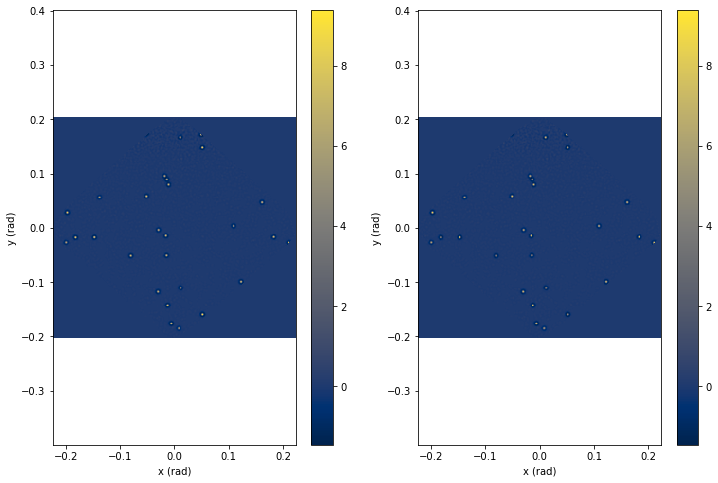

In [26]:
fig = plt.figure(1,figsize=(12,8))
ax = fig.add_subplot(121)

plot = ax.pcolormesh(arr_bx_plot, arr_by_plot, cwt_map_og[:,:,0], cmap='cividis', shading='flat'
                     , norm=mpl.colors.Normalize(vmin=np.min(cwt_map_og[:,:,0]), 
                                                 vmax=np.max(cwt_map_og[:,:,0])))
plt.colorbar(plot)
plt.xlabel('x (rad)')
plt.ylabel('y (rad)')
ax.axis('equal')

ax = fig.add_subplot(122)

plot = ax.pcolormesh(arr_bx_plot, arr_by_plot, cwt_map_test[:,:,0], cmap='cividis', shading='flat'
                     , norm=mpl.colors.Normalize(vmin=np.min(cwt_map_test[:,:,0]), 
                                                 vmax=np.max(cwt_map_test[:,:,0])))
plt.colorbar(plot)
plt.xlabel('x (rad)')
plt.ylabel('y (rad)')
ax.axis('equal')